# Volatility Forecasting with Transformers

**Just run all cells**.

**Adapting Week 3 Capstone Transformer Architecture for Volatility Prediction:**



Made with extensive help from Claude.ai and Gemini.

When I run it in my Colab, I can use the T4 GPU, but it runs also on CPUs - just slower.


This notebook demonstrates how the same transformer architecture used for character-level language modeling in Week 3 can be applied to volatility forecasting.

## Conclusions
The good news: the model works. The bad news: the transformer model performs bad measured by e.g. Root Mean Squared Error and Mean Absolute Error. It's no surprise given the complexity of volatility prediction. However the 'Multi-Head Attention Mecanism' in the transformer model is here used for structures in volatility.

## Key Connections to Week 3

| Language Model | Volatility Model |
|----------------|------------------|
| Characters → Token IDs | Returns → Feature vectors |
| Embedding layer | Linear projection layer |
| Predict next character | Predict future volatility |
| Cross-entropy loss | MSE loss |
| Softmax over vocabulary | Single regression output |

The core transformer blocks (attention, FFN, residuals, layer norm) remain exactly the same.

From README.md
# Capstone Week 3 - Transformer Models Summary
I have made the Capstone Week 3 with extensive help from Claude.ai and Gemini.
I have spent a lot of time working to understand the core concepts - as the attention mechanism, masks, positional encoding, etc. The main part of my time was spent on understanding the mechanisms - not on code generation.

But I could not help challenging Claude.ai to make an implementation for volatility prediction (from SPY):
The point would be to reuse as many parts from Capstone Week 3 as possible. I used data from my Alpaca.markets subscription when running locally (using my keys) or publicly on a csv file hosted on GitHub.

## Conclusion:
Even using Claude.ai and Gemini I think it was very useful to tweak the parameters and devices: not so surprising very slow with CPU, faster with T4 GPU. Most of the loss progress was done after 2000 steps. With the Capstone Week 3 file I worked with 4 and 8 attention heads - and even for num_heads=1. Differences were noticeable but not dramatic.  

The transformer for volatility prediction (with num_heads=4) achieved RMSE of  7.673% vs EWMA's 3.596%. In the Mincer-Zarnowitz regression R² was 0.0003 vs 0.5158 for EWMA. That's hardly surprising. The transformer underperformed EWMA baselines, which highlights that architectural sophistication doesn't guarantee success on noisy (very few) financial data. With only ~1,245 days of SPY data and 128 test sequences, the model was not able to learn much. The most valuable insight was understanding how multi-head attention transformer models can learn content-based dependencies between inputs.

I have created two notebooks:

## 1. CapstoneWeek3 Notebook: Character-Level Language Model

This notebook implements a decoder-only transformer for character-level language modeling.
The model uses scaled dot-product attention, multi-head attention, and transformer blocks with Pre-LN structure.
Training uses cross-entropy loss to predict the next character from a small text corpus.
Key components include: `scaled_dot_product_attention`, `MultiHeadAttention`, `TransformerBlock`, and `PositionalEncoding`.
The model generates text samples using temperature-controlled sampling after training on approx. 35,000 characters.

## 2. Vol_transformer_public Notebook: Volatility Forecasting Model

This notebook adapts the same transformer architecture for predicting 5-day forward realized volatility of SPY.
Input features include log returns, absolute returns, high-low range, volume changes, and historical volatility.
The model outputs a single regression value (MSE loss) instead of vocabulary probabilities.
Evaluation uses Mincer-Zarnowitz regression and compares against naive and EWMA baseline forecasts.
Data comes from Alpaca.markets API (or GitHub CSV fallback) with proper chronological train/val/test splits.

## 3. Comments on Using Transformers for Volatility Prediction

The attention mechanism enables in principle the model to identify which past days are most relevant for current volatility.
Unlike EWMA which use fixed decay weights, transformers can learn dynamic, content-based dependencies.
Volatility clustering and regime changes could benefit from the model's ability to attend to distant past events.
The architecture generalizes well because attention doesn't distinguish between text tokens and numerical features.
However, financial data is noisier and less structured than language, making patterns harder to learn reliably. As mentioned above, the model was not able to learn much with only ~1,245 days of SPY data and 128 test sequences.

## 4. Key Differences Between the Two Models

| Aspect | Language Model | Volatility Model |
|--------|----------------|------------------|
| **Input Layer** | `nn.Embedding(vocab_size, d_model)` - discrete tokens | `nn.Linear(num_features, d_model)` - continuous features |
| **Output Layer** | `nn.Linear(d_model, vocab_size)` - softmax over vocabulary | `nn.Linear(d_model, 1)` - single regression value |
| **Loss Function** | Cross-entropy (classification) | Mean Squared Error (regression) |
| **Evaluation** | Loss, bits-per-character, qualitative samples | RMSE, MAE, Mincer-Zarnowitz R² |
| **Data Split** | Random or sequential (order matters less for training) | Strictly chronological (no future data leakage) |


## 1. Setup and Data Fetching
I use data from Alpaca.markets - but when running public the Transformer model uses just a historical CSV file on GitHub with data

In [ ]:
# Install alpaca-py if needed
!pip install alpaca-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seeds for reproducibility
torch.manual_seed(100)
np.random.seed(100)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


I have ensured that the keys are in Colab's Secrets Manager but
if run publicly we load data from a GitHUB CSV

In [ ]:
from google.colab import userdata
from google.colab.userdata import TimeoutException, SecretNotFoundError

# Initialize API keys to None
ALPACA_API_KEY = None
ALPACA_SECRET_KEY = None

try:
    # Attempt to retrieve API keys from Colab's Secrets Manager
    ALPACA_API_KEY = userdata.get("ALPACA_API_KEY")
    ALPACA_SECRET_KEY = userdata.get("ALPACA_SECRET_KEY")
except (TimeoutException, SecretNotFoundError) as e:
    print(f"WARNING: Alpaca API keys not found or timed out from Colab's Secrets Manager: {e}")
    print("         Data will be loaded from the GitHub CSV as a fallback.")
except Exception as e:
    print(f"An unexpected error occurred while retrieving Alpaca API keys: {e}")
    print("         Data will be loaded from the GitHub CSV as a fallback.")


# Debugging: Print whether the keys were retrieved
print(f"ALPACA_API_KEY status: {'Available' if ALPACA_API_KEY is not None else 'Not available'}")
print(f"ALPACA_SECRET_KEY status: {'Available' if ALPACA_SECRET_KEY is not None else 'Not available'}")

# Provide a clear message about the chosen data source strategy
if ALPACA_API_KEY is None or ALPACA_SECRET_KEY is None:
    print("Alpaca API keys not fully loaded. Data will attempt to load from GitHub CSV.")
else:
    print("Alpaca API keys loaded successfully. Data will attempt to load from Alpaca API.")

An unexpected error occurred while retrieving Alpaca API keys: Notebook does not have access to secret ALPACA_API_KEY
         Data will be loaded from the GitHub CSV as a fallback.
ALPACA_API_KEY status: Not available
ALPACA_SECRET_KEY status: Not available
Alpaca API keys not fully loaded. Data will attempt to load from GitHub CSV.


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Import Alpaca components (will be used if keys are available)
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

def fetch_spy_data(api_key, secret_key, start_date, end_date):
    """
    Fetch daily OHLCV bars for SPY from Alpaca.

    Returns a DataFrame with columns: open, high, low, close, volume
    """
    client = StockHistoricalDataClient(api_key, secret_key)

    request_params = StockBarsRequest(
        symbol_or_symbols="SPY",
        timeframe=TimeFrame.Day,
        start=start_date,
        end=end_date
    )

    bars = client.get_stock_bars(request_params)
    df_alpaca = bars.df

    # Reset index to get timestamp as column, then clean up
    df_alpaca = df_alpaca.reset_index()
    df_alpaca = df_alpaca.drop(columns=['symbol'])  # Remove symbol column since we only have SPY
    df_alpaca = df_alpaca.rename(columns={'timestamp': 'date'})
    df_alpaca['date'] = pd.to_datetime(df_alpaca['date']).dt.date
    df_alpaca = df_alpaca.set_index('date')

    return df_alpaca

# Define GitHub CSV URL
github_csv_url = 'https://raw.githubusercontent.com/thomasplato/TheAIEngineer_Week3/main/spy_daily.csv'

df = None # Initialize df to None

# Attempt to load data from Alpaca API first if keys are available
if ALPACA_API_KEY and ALPACA_SECRET_KEY:
    print("Alpaca API keys available. Attempting to fetch SPY data from Alpaca API...")
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365) # Fetch 5 years of daily data
    try:
        df = fetch_spy_data(ALPACA_API_KEY, ALPACA_SECRET_KEY, start_date, end_date)
        if df is not None and len(df) > 0:
            print(f"Retrieved {len(df)} trading days from Alpaca API.")
        else:
            print("WARNING: Alpaca API returned an empty DataFrame. Falling back to GitHub CSV.")
            df = None # Set to None to trigger fallback
    except Exception as e:
        print(f"ERROR: Could not fetch data from Alpaca API: {e}")
        print("Falling back to GitHub CSV.")
        df = None # Set to None to trigger fallback
else:
    print("Alpaca API keys not fully available. Loading data from GitHub CSV.")

# If df is still None (API failed or keys not present), load from GitHub CSV
if df is None or len(df) == 0:
    print(f"Loading SPY data from GitHub CSV: {github_csv_url}")
    try:
        df = pd.read_csv(github_csv_url, index_col='date', parse_dates=True)
        print(f"Retrieved {len(df)} trading days from CSV.")
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load data from GitHub CSV. Please check the URL or your network connection: {e}")
        df = pd.DataFrame() # Initialize an empty DataFrame to avoid downstream errors

print("\nFirst 5 rows of the loaded DataFrame:")
print(df.head())

Alpaca API keys not fully available. Loading data from GitHub CSV.
Loading SPY data from GitHub CSV: https://raw.githubusercontent.com/thomasplato/TheAIEngineer_Week3/main/spy_daily.csv
Retrieved 1255 trading days from CSV.

First 5 rows of the loaded DataFrame:
              open    high     low   close      volume  trade_count  \
date                                                                  
2020-12-01  365.57  367.68  364.93  365.84  76822159.0     378052.0   
2020-12-02  364.82  366.96  364.20  366.82  47081427.0     275077.0   
2020-12-03  366.68  368.19  365.50  366.67  64123777.0     327424.0   
2020-12-04  367.32  369.85  367.22  369.78  51459007.0     252857.0   
2020-12-07  369.02  369.62  367.72  369.16  50031951.0     266705.0   

                  vwap  
date                    
2020-12-01  366.371124  
2020-12-02  365.995040  
2020-12-03  366.952993  
2020-12-04  368.995412  
2020-12-07  368.815157  


In [ ]:
df.tail(2)

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2025-11-26,677.63,681.700,676.72,679.68,71879597.0,881264.0,680.092720
2025-11-28,680.86,683.665,680.50,683.39,49212030.0,568720.0,682.350281


## 2. Feature Engineering

We'll compute:
- **Log returns**: The standard way to measure price changes
- **Realized volatility**: Our target variable (what we're predicting)
- **Additional features**: To help the model learn patterns

In [ ]:
def compute_features(df, vol_window=5):
    """
    Compute features for volatility prediction.

    Features (per day):
    - log_return: log(close_t / close_{t-1})
    - abs_return: |log_return| (proxy for daily vol)
    - high_low_range: (high - low) / close (intraday volatility proxy)
    - volume_change: log(volume_t / volume_{t-1})
    - realized_vol_5d: rolling 5-day realized volatility (historical)

    Target:
    - forward_vol_5d: realized vol over the NEXT 5 days
    """
    data = df.copy()

    # Log returns
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))

    # Absolute return (simple vol proxy)
    data['abs_return'] = np.abs(data['log_return'])

    # High-low range (intraday volatility)
    data['high_low_range'] = (data['high'] - data['low']) / data['close']

    # Volume change
    data['volume_change'] = np.log(data['volume'] / data['volume'].shift(1))

    # Historical realized volatility (rolling window)
    # Annualized: multiply by sqrt(252)
    data['realized_vol_5d'] = data['log_return'].rolling(window=vol_window).std() * np.sqrt(252)

    # FORWARD realized volatility - this is our TARGET
    # We shift BACKWARDS so that row t contains the vol computed from days t+1 to t+5
    data['forward_vol_5d'] = data['log_return'].shift(-vol_window).rolling(window=vol_window).std() * np.sqrt(252)
    # Fix the shift direction for forward-looking
    data['forward_vol_5d'] = data['log_return'].rolling(window=vol_window).std().shift(-vol_window) * np.sqrt(252)

    # Drop rows with NaN (beginning and end of series)
    data = data.dropna()

    return data

df_features = compute_features(df)
print(f"Dataset size after feature engineering: {len(df_features)} days")
print(f"\nFeature columns: {list(df_features.columns)}")
df_features.head(2)

Dataset size after feature engineering: 1245 days

Feature columns: ['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'log_return', 'abs_return', 'high_low_range', 'volume_change', 'realized_vol_5d', 'forward_vol_5d']


,open,high,low,close,volume,trade_count,vwap,log_return,abs_return,high_low_range,volume_change,realized_vol_5d,forward_vol_5d
date,,,,,,,,,,,,,
2020-12-08,367.72,370.78,367.67,370.19,45099196.0,226746.0,369.577640,0.002786,0.002786,0.008401,-0.103797,0.062141,0.128511
2020-12-09,370.88,371.05,365.95,366.77,75525045.0,396722.0,368.007762,-0.009281,0.009281,0.013905,0.515600,0.102947,0.101168


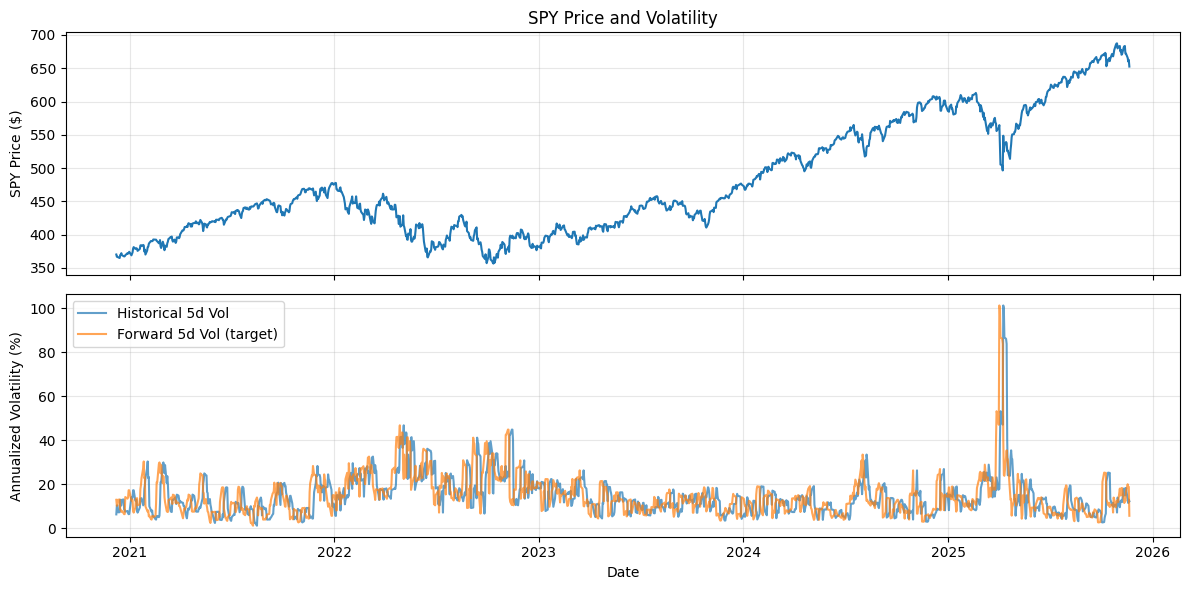


Volatility statistics:
  Mean: 14.69%
  Std:  9.39%
  Min:  1.06%
  Max:  101.20%


In [ ]:
# Visualize the target variable
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(df_features.index, df_features['close'])
axes[0].set_ylabel('SPY Price ($)')
axes[0].set_title('SPY Price and Volatility')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_features.index, df_features['realized_vol_5d'] * 100, label='Historical 5d Vol', alpha=0.7)
axes[1].plot(df_features.index, df_features['forward_vol_5d'] * 100, label='Forward 5d Vol (target)', alpha=0.7)
axes[1].set_ylabel('Annualized Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVolatility statistics:")
print(f"  Mean: {df_features['forward_vol_5d'].mean()*100:.2f}%")
print(f"  Std:  {df_features['forward_vol_5d'].std()*100:.2f}%")
print(f"  Min:  {df_features['forward_vol_5d'].min()*100:.2f}%")
print(f"  Max:  {df_features['forward_vol_5d'].max()*100:.2f}%")

## 3. Dataset Preparation

Just like in Week 3, we create sequences. But instead of character IDs, each "token" is now a feature vector for one day.

```
Week 3 (Language Model):
  Input: [token_id_1, token_id_2, ..., token_id_64]  shape: (64,)
  → Embedding → (64, d_model)

This notebook (Volatility Model):
  Input: [[features_day_1], [features_day_2], ..., [features_day_64]]  shape: (64, num_features)
  → Linear projection → (64, d_model)
```

In [ ]:
# Select features for the model
FEATURE_COLUMNS = ['log_return', 'abs_return', 'high_low_range', 'volume_change', 'realized_vol_5d']
TARGET_COLUMN = 'forward_vol_5d'

# Extract features and target as numpy arrays
features = df_features[FEATURE_COLUMNS].values.astype(np.float32)
targets = df_features[TARGET_COLUMN].values.astype(np.float32)

print(f"Features shape: {features.shape}  (num_days, num_features)")
print(f"Targets shape: {targets.shape}")

# Normalize features (important for training stability)
# We'll compute statistics on training set only, then apply to all
# For now, just standardize globally (will fix in train/test split)
feature_means = features.mean(axis=0)
feature_stds = features.std(axis=0)
features_normalized = (features - feature_means) / (feature_stds + 1e-8)

# Also normalize target (helps with learning)
target_mean = targets.mean()
target_std = targets.std()
targets_normalized = (targets - target_mean) / (target_std + 1e-8)

print(f"\nFeature means: {feature_means}")
print(f"Feature stds: {feature_stds}")
print(f"Target mean: {target_mean:.4f}, std: {target_std:.4f}")

Features shape: (1245, 5)  (num_days, num_features)
Targets shape: (1245,)

Feature means: [0.00045753 0.0076538  0.01198288 0.00095989 0.14656012]
Feature stds: [0.01080959 0.00764696 0.00795141 0.28565863 0.0939252 ]
Target mean: 0.1469, std: 0.0939


In [ ]:
# =============================================================================
# CHRONOLOGICAL TRAIN / VALIDATION / TEST SPLIT
# =============================================================================
# CRITICAL: In finance, we MUST split chronologically, not randomly!
# Random splits would let the model "peek" at future data.

n_total = len(features_normalized)
n_train = int(0.7 * n_total)  # 70% training
n_val = int(0.15 * n_total)   # 15% validation
# Remaining ~15% for test

train_features = features_normalized[:n_train]
train_targets = targets_normalized[:n_train]

val_features = features_normalized[n_train:n_train+n_val]
val_targets = targets_normalized[n_train:n_train+n_val]

test_features = features_normalized[n_train+n_val:]
test_targets = targets_normalized[n_train+n_val:]

# Keep unnormalized test targets for final evaluation
test_targets_original = targets[n_train+n_val:]

print(f"Training set: {len(train_features)} days")
print(f"Validation set: {len(val_features)} days")
print(f"Test set: {len(test_features)} days")

# Show date ranges
dates = df_features.index.tolist()
print(f"\nTraining period: {dates[0]} to {dates[n_train-1]}")
print(f"Validation period: {dates[n_train]} to {dates[n_train+n_val-1]}")
print(f"Test period: {dates[n_train+n_val]} to {dates[-1]}")

Training set: 871 days
Validation set: 186 days
Test set: 188 days

Training period: 2020-12-08 00:00:00 to 2024-05-24 00:00:00
Validation period: 2024-05-28 00:00:00 to 2025-02-24 00:00:00
Test period: 2025-02-25 00:00:00 to 2025-11-20 00:00:00


In [ ]:
def create_sequences(features, targets, seq_length):
    """
    Create sequences for the transformer.

    This is analogous to Week 3's get_batch, but we create all sequences upfront.

    For each position t, we create:
      X: features from days [t-seq_length+1, ..., t]
      y: target at day t (the forward volatility we want to predict)

    Returns:
      X: (num_sequences, seq_length, num_features)
      y: (num_sequences,)
    """
    X, y = [], []

    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(targets[i-1])  # Target for the last day in the sequence

    return np.array(X), np.array(y)

# Sequence length (context window) - analogous to block_size in Week 3
SEQ_LENGTH = 60  # 60 trading days ≈ 3 months of history

X_train, y_train = create_sequences(train_features, train_targets, SEQ_LENGTH)
X_val, y_val = create_sequences(val_features, val_targets, SEQ_LENGTH)
X_test, y_test = create_sequences(test_features, test_targets, SEQ_LENGTH)
_, y_test_original = create_sequences(test_features, test_targets_original, SEQ_LENGTH)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"\nEach sequence: {SEQ_LENGTH} days × {X_train.shape[2]} features")

Training sequences: (811, 60, 5)
Validation sequences: (126, 60, 5)
Test sequences: (128, 60, 5)

Each sequence: 60 days × 5 features


In [ ]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders for batching
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches per epoch: {len(train_loader)}")

Batches per epoch: 26


## 4. Transformer Model for Volatility

This is the **same architecture** as Week 3, with two key changes:
1. **Input**: Linear projection instead of embedding (features are already continuous)
2. **Output**: Single regression value instead of vocabulary logits

In [ ]:
# =============================================================================
# BUILDING BLOCKS (same as Week 3)
# =============================================================================

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled dot-product attention - IDENTICAL to Week 3.

    Q, K, V: (..., T, d_k) tensors
    mask: optional boolean mask
    returns: (..., T, d_v)
    """
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask, float('-inf'))

    attn_weights = F.softmax(scores, dim=-1)
    output = attn_weights @ V

    return output


def make_causal_mask(T, device=None):
    """Create causal mask - IDENTICAL to Week 3."""
    mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, T, T)

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention - IDENTICAL to Week 3.

    The attention mechanism doesn't know or care whether it's processing
    character embeddings or financial features!
    """
    def __init__(self, d_model, num_heads, dropout=0.0, causal=True):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.causal = causal

        self.proj_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.proj_out = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, D = x.shape

        qkv = self.proj_qkv(x)  # (B, T, 3*D)
        qkv = qkv.view(B, T, 3, self.num_heads, self.d_head)
        Q, K, V = qkv.unbind(dim=2)  # each: (B, T, H, d_head)

        Q = Q.transpose(1, 2)  # (B, H, T, d_head)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        mask = make_causal_mask(T, device=x.device) if self.causal else None
        Y = scaled_dot_product_attention(Q, K, V, mask=mask)  # (B, H, T, d_head)

        Y = Y.transpose(1, 2).contiguous().view(B, T, D)  # (B, T, D)
        Y = self.proj_out(Y)
        Y = self.dropout(Y)
        return Y

In [ ]:
class TransformerBlock(nn.Module):
    """
    Single transformer block - IDENTICAL to Week 3.

    Pre-LN structure:
      x' = x + MHA(LN(x))
      y  = x' + FFN(LN(x'))
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, causal=True):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads, dropout, causal)

        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding - IDENTICAL to Week 3.

    Position information is just as important for time series:
    - In language: word order matters ("dog bites man" vs "man bites dog")
    - In finance: time order matters (yesterday's return vs last month's)
    """
    def __init__(self, d_model, max_len=512):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [ ]:
class VolatilityTransformer(nn.Module):
    """
    Transformer for volatility prediction.

    Key differences from TinyTransformerLM (Week 3):

    1. INPUT: Instead of nn.Embedding(vocab_size, d_model), we use
       nn.Linear(num_features, d_model) because our inputs are already
       continuous feature vectors, not discrete token IDs.

    2. OUTPUT: Instead of nn.Linear(d_model, vocab_size) for next-token
       prediction, we use nn.Linear(d_model, 1) for regression.

    Everything in between (positional encoding, transformer blocks) is
    EXACTLY THE SAME.
    """
    def __init__(self, num_features, d_model, num_heads, num_layers, d_ff,
                 max_len=512, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # CHANGE 1: Linear projection instead of embedding
        # Week 3: self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.input_projection = nn.Linear(num_features, d_model)

        # Same as Week 3
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)

        # Same as Week 3
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout, causal=True)
            for _ in range(num_layers)
        ])

        # Same as Week 3
        self.ln_final = nn.LayerNorm(d_model)

        # CHANGE 2: Regression output instead of classification
        # Week 3: self.lm_head = nn.Linear(d_model, vocab_size)
        self.output_head = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Model initialized with {n_params:,} parameters")

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        """
        Forward pass.

        Args:
            x: Feature sequences, shape (B, T, num_features)
               Compare to Week 3: Token IDs, shape (B, T)

        Returns:
            predictions: Volatility predictions, shape (B,)
                         We only predict for the last position in each sequence.
        """
        # Project features to model dimension
        # Week 3: x = self.token_embedding(x)  # (B, T) -> (B, T, d_model)
        x = self.input_projection(x)  # (B, T, num_features) -> (B, T, d_model)

        # Add positional encoding (same as Week 3)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through transformer blocks (same as Week 3)
        for block in self.blocks:
            x = block(x)

        # Final layer norm (same as Week 3)
        x = self.ln_final(x)

        # Output projection - only use the LAST position
        # Week 3: return self.lm_head(x)  # (B, T, vocab_size) for all positions
        x = x[:, -1, :]  # (B, d_model) - take last timestep
        return self.output_head(x).squeeze(-1)  # (B,)

In [ ]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

config = {
    # Model architecture
    'num_features': len(FEATURE_COLUMNS),  # 5 features per day
    'd_model': 64,           # Same as Week 3
    'num_heads': 4,          # Same as Week 3
    'num_layers': 4,         # Same as Week 3
    'd_ff': 256,             # Same as Week 3 (4 * d_model)
    'max_len': 512,          # Same as Week 3
    'dropout': 0.1,          # Same as Week 3

    # Training (similar to Week 3)
    'learning_rate': 3e-4,
    'num_epochs': 50,
    'patience': 20,          # Early stopping patience
}

# Create model
model = VolatilityTransformer(
    num_features=config['num_features'],
    d_model=config['d_model'],
    num_heads=config['num_heads'],
    num_layers=config['num_layers'],
    d_ff=config['d_ff'],
    max_len=config['max_len'],
    dropout=config['dropout']
).to(device)

# Quick test
test_input = torch.randn(2, SEQ_LENGTH, len(FEATURE_COLUMNS)).to(device)
test_output = model(test_input)
print(f"\nTest input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")

Model initialized with 199,489 parameters

Test input shape: torch.Size([2, 60, 5])
Test output shape: torch.Size([2])


## 5. Training Loop

In [ ]:
def train_epoch(model, loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)

        # Loss: MSE instead of cross-entropy
        # Week 3: loss = F.cross_entropy(logits.view(-1, V), targets.view(-1))
        loss = F.mse_loss(predictions, y_batch)

        # Backward pass (same as Week 3)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * len(y_batch)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device):
    """Evaluate on a dataset."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(X_batch)
        loss = F.mse_loss(predictions, y_batch)

        total_loss += loss.item() * len(y_batch)
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_targets)

In [ ]:
# =============================================================================
# TRAINING
# =============================================================================

optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Learning rate scheduler (optional, but helps)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training history
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...")
print("-" * 60)

for epoch in range(config['num_epochs']):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, _, _ = evaluate(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vol_model.pt')
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if patience_counter >= config['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("-" * 60)
print("Training complete!")

# Load best model for evaluation
model.load_state_dict(torch.load('best_vol_model.pt'))

Starting training...
------------------------------------------------------------
Epoch   1 | Train Loss: 0.765902 | Val Loss: 0.496192
Epoch   5 | Train Loss: 0.462375 | Val Loss: 0.359954
Epoch  10 | Train Loss: 0.416065 | Val Loss: 0.335221
Epoch  15 | Train Loss: 0.399164 | Val Loss: 0.333345
Epoch  20 | Train Loss: 0.398734 | Val Loss: 0.340312
Epoch  25 | Train Loss: 0.380640 | Val Loss: 0.342459

Early stopping at epoch 29
------------------------------------------------------------
Training complete!


<All keys matched successfully>

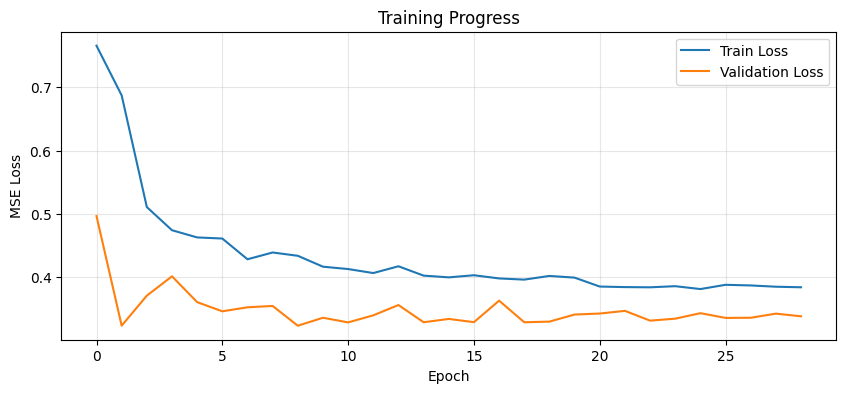

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Evaluation and Comparison to Baselines

This is where we answer: **Is our transformer actually useful?**

We compare against simple baselines:
1. **Naive**: Predict that tomorrow's vol = today's vol
2. **Historical average**: Predict the average vol from training set
3. **EWMA**: Exponentially weighted moving average of past vol

In [ ]:
# Get transformer predictions on test set
test_loss, preds_normalized, targets_normalized = evaluate(model, test_loader, device)

# Convert back to original scale
preds_transformer = preds_normalized * target_std + target_mean
actuals = y_test_original  # Already in original scale

print(f"Test MSE (normalized): {test_loss:.6f}")

Test MSE (normalized): 0.667913


In [ ]:
# =============================================================================
# BASELINE MODELS
# =============================================================================

# Baseline 1: Naive (predict last observed vol)
# For each test point, use the realized_vol_5d from the last day in the input sequence
naive_preds = test_features[SEQ_LENGTH-1:-1, FEATURE_COLUMNS.index('realized_vol_5d')]
naive_preds = naive_preds * feature_stds[FEATURE_COLUMNS.index('realized_vol_5d')] + feature_means[FEATURE_COLUMNS.index('realized_vol_5d')]

# Baseline 2: Historical average from training set
train_vol_mean = targets[:n_train].mean()
hist_avg_preds = np.full_like(actuals, train_vol_mean)

# Baseline 3: EWMA with span=10
# We need to reconstruct the vol series and apply EWMA
vol_series = targets[n_train+n_val:]  # Test period vol
ewma_preds = pd.Series(vol_series).ewm(span=10).mean().shift(1).values[SEQ_LENGTH:]
# Handle the first prediction (no history)
ewma_preds = np.nan_to_num(ewma_preds, nan=train_vol_mean)

# Align lengths (EWMA might have different length)
min_len = min(len(actuals), len(naive_preds), len(ewma_preds))
actuals = actuals[:min_len]
preds_transformer = preds_transformer[:min_len]
naive_preds = naive_preds[:min_len]
hist_avg_preds = hist_avg_preds[:min_len]
ewma_preds = ewma_preds[:min_len]

In [ ]:
def compute_metrics(actuals, predictions, name):
    """Compute evaluation metrics."""
    # RMSE (Root Mean Squared Error): Measures the average magnitude of the errors.
    # Gives higher weight to larger errors due to squaring.
    mse = np.mean((actuals - predictions) ** 2)
    rmse = np.sqrt(mse)

    # MAE (Mean Absolute Error): Measures the average magnitude of errors without considering direction.
    # More robust to outliers than RMSE.
    mae = np.mean(np.abs(actuals - predictions))

    # Correlation (Corr): Measures the linear relationship between actual and predicted values.
    # A high positive correlation (close to 1) is desired, indicating predictions move in tandem with actuals.
    corr = np.corrcoef(actuals, predictions)[0, 1]

    # QLIKE loss (Quasi-Likelihood Error): A volatility-specific loss function that penalizes
    # under-predictions more heavily than over-predictions, reflecting the higher cost of underestimating risk.
    eps = 1e-8
    ratio = (actuals + eps) / (predictions + eps)
    qlike = np.mean(ratio - np.log(ratio) - 1)

    print(f"{name:20s} | RMSE: {rmse*100:6.3f}% | MAE: {mae*100:6.3f}% | Corr: {corr:.4f} | QLIKE: {qlike:.4f}")

    return {'rmse': rmse, 'mae': mae, 'corr': corr, 'qlike': qlike}

print("=" * 80)
print("MODEL COMPARISON ON TEST SET")
print("=" * 80)
print(f"{'Model':20s} | {'RMSE':>10s} | {'MAE':>10s} | {'Corr':>8s} | {'QLIKE':>8s}")
print("-" * 80)

metrics = {}
metrics['Transformer'] = compute_metrics(actuals, preds_transformer, 'Transformer')
metrics['Naive (last vol)'] = compute_metrics(actuals, naive_preds, 'Naive (last vol)')
metrics['Historical Avg'] = compute_metrics(actuals, hist_avg_preds, 'Historical Avg')
metrics['EWMA(10)'] = compute_metrics(actuals, ewma_preds, 'EWMA(10)')

print("=" * 80)

MODEL COMPARISON ON TEST SET
Model                |       RMSE |        MAE |     Corr |    QLIKE
--------------------------------------------------------------------------------
Transformer          | RMSE:  7.673% | MAE:  6.005% | Corr: 0.0159 | QLIKE: 0.1743
Naive (last vol)     | RMSE:  7.222% | MAE:  5.336% | Corr: -0.0080 | QLIKE: 0.3205
Historical Avg       | RMSE:  6.898% | MAE:  6.134% | Corr: nan | QLIKE: 0.1792
EWMA(10)             | RMSE:  3.596% | MAE:  2.593% | Corr: 0.7182 | QLIKE: 0.0550


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


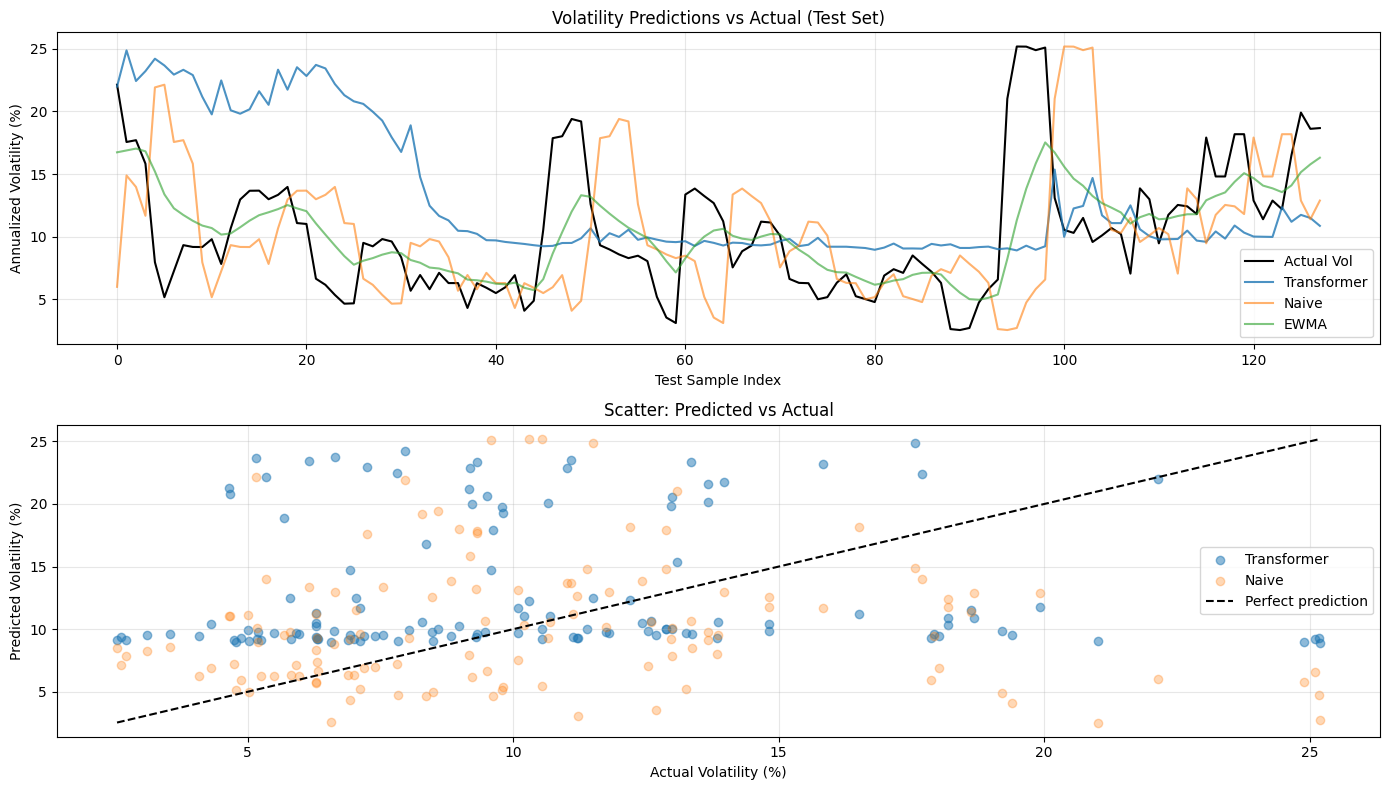

In [ ]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series plot
ax1 = axes[0]
ax1.plot(actuals * 100, label='Actual Vol', color='black', linewidth=1.5)
ax1.plot(preds_transformer * 100, label='Transformer', alpha=0.8)
ax1.plot(naive_preds * 100, label='Naive', alpha=0.6)
ax1.plot(ewma_preds * 100, label='EWMA', alpha=0.6)
ax1.set_ylabel('Annualized Volatility (%)')
ax1.set_xlabel('Test Sample Index')
ax1.set_title('Volatility Predictions vs Actual (Test Set)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot (predicted vs actual)
ax2 = axes[1]
ax2.scatter(actuals * 100, preds_transformer * 100, alpha=0.5, label='Transformer')
ax2.scatter(actuals * 100, naive_preds * 100, alpha=0.3, label='Naive')

# Perfect prediction line
min_val = min(actuals.min(), preds_transformer.min()) * 100
max_val = max(actuals.max(), preds_transformer.max()) * 100
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

ax2.set_xlabel('Actual Volatility (%)')
ax2.set_ylabel('Predicted Volatility (%)')
ax2.set_title('Scatter: Predicted vs Actual')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# MINCER-ZARNOWITZ REGRESSION
# =============================================================================
# A standard test for volatility forecasts:
# Regress: actual_vol = alpha + beta * predicted_vol + error
#
# A perfect forecast would have alpha=0, beta=1
# - alpha > 0 means systematic underestimation
# - beta < 1 means predictions don't vary enough

from scipy import stats

def mincer_zarnowitz(actuals, predictions, name):
    """Run Mincer-Zarnowitz regression."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, actuals)

    print(f"{name}:")
    print(f"  α (intercept) = {intercept:.6f}  (ideal: 0)")
    print(f"  β (slope)     = {slope:.4f}       (ideal: 1)")
    print(f"  R²            = {r_value**2:.4f}")
    print()

    return intercept, slope, r_value**2

print("=" * 60)
print("MINCER-ZARNOWITZ REGRESSION RESULTS")
print("=" * 60)
print()

mz_transformer = mincer_zarnowitz(actuals, preds_transformer, 'Transformer')
mz_naive = mincer_zarnowitz(actuals, naive_preds, 'Naive')
mz_ewma = mincer_zarnowitz(actuals, ewma_preds, 'EWMA')

MINCER-ZARNOWITZ REGRESSION RESULTS

Transformer:
  α (intercept) = 0.102040  (ideal: 0)
  β (slope)     = 0.0156       (ideal: 1)
  R²            = 0.0003

Naive:
  α (intercept) = 0.104901  (ideal: 0)
  β (slope)     = -0.0081       (ideal: 1)
  R²            = 0.0001

EWMA:
  α (intercept) = -0.016057  (ideal: 0)
  β (slope)     = 1.1573       (ideal: 1)
  R²            = 0.5158



## 7. Summary

### What We Built

We adapted the **exact same transformer architecture** from Week 3:
- Same `MultiHeadAttention` class
- Same `TransformerBlock` class  
- Same `PositionalEncoding` class

The only changes:
1. **Input layer**: `nn.Linear(num_features, d_model)` instead of `nn.Embedding(vocab_size, d_model)`
2. **Output layer**: `nn.Linear(d_model, 1)` for regression instead of `nn.Linear(d_model, vocab_size)` for classification
3. **Loss function**: MSE instead of cross-entropy

### Evaluation Approach

Unlike language modeling where evaluation is tricky, volatility forecasting has clear metrics:
- **Ground truth**: We can compute actual realized volatility after the fact
- **Baselines**: EWMA, naive models give us something concrete to beat
- **Statistical tests**: Mincer-Zarnowitz regression tells us if predictions are well-calibrated
